In [1]:
import ast
import pandas as pd
from IPython.display import Image
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import squarify
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import style
import seaborn as sns
sns.set()
%matplotlib inline
init_notebook_mode(connected=True)

# Load Data

In [2]:
channels = pd.read_csv('../info/channels_labeled.csv')
channels.head(3)

,channel_id,channel_name,created_date,created_by,folder,actual_name,folder_name
0,C0GQ664PQ,general,2015-12-16,Paul,others,general,general
1,C0GQ0GH1S,random,2015-12-16,Paul,others,random,random
2,CBH1274KV,msan501,2018-07-01,Terence,mod1_summer,Computation for Analytics,computation_for_analytics


In [3]:
users = pd.read_csv("../info/members_labeled.csv")
users.head(3)

,member_id,member_name,member_type,country
0,U9WDUU4LE,GitHub,bot,NaN
1,USLACKBOT,Slackbot,bot,NaN
2,UAZK0M7RR,Polly,bot,NaN


In [4]:
messages = pd.read_csv("../info/messages.csv")
messages['count_messages'] = 1
messages.head(3)

,text,reactions,ts,user,parent_user_id,files,module,course,count_reactions,date,count_messages
0,<@UBMMHRHE2> has left the channel,NaN,2019-04-26 11:08:19,UBMMHRHE2,NaN,NaN,mod1_summer,computation_for_analytics,0,2019-04-26,1
1,<@UBKUL888Y> has left the channel,NaN,2019-04-09 10:44:11,UBKUL888Y,NaN,NaN,mod1_summer,computation_for_analytics,0,2019-04-09,1
2,<@UBLC0B98U> has left the channel,NaN,2019-03-27 20:38:38,UBLC0B98U,NaN,NaN,mod1_summer,computation_for_analytics,0,2019-03-27,1


# Summary of Data

### Histogram

In [5]:
messages.groupby(['user']).sum().sort_values(by=['count_reactions'], ascending=False).head(3)

,count_reactions,count_messages
user,,
UBMH4GT55,2319,651
U1T2RJNRZ,2172,629
U1NC3UMSQ,2152,557


In [6]:
trace1 = go.Histogram(x=list(messages.groupby(['user']).sum().count_reactions.values),
                      opacity=0.75, nbinsx = 5, name="Reactions")

In [7]:
data = [trace1]

In [8]:
layout = go.Layout(barmode='overlay',
                   title='Reactions received',
                   xaxis=dict(title='Number of reactions received'),
                   yaxis=dict(title='Number of users')
                  )

In [9]:
fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Barplot

In [10]:
df = messages.groupby(['module']).sum().reset_index().sort_values(by=['count_reactions'], ascending=True)
df['courses'] = df['module'].apply(lambda mod: "".join([f"- {course}<br>" for course in channels[channels['folder']==mod].actual_name.unique()]))
df

,module,count_reactions,count_messages,courses
3,mod4_winter,945,503,- Distributed Data Systems<br>
0,mod1_summer,2274,3157,- Computation for Analytics<br>- Linear Algebr...
1,mod2_fall1,3594,3335,- Communications for Analytics<br>- Data Acqui...
2,mod3_fall2,3698,1835,- Introduction to Machine Learning<br>- Distri...
5,mod6_spring2,3822,1554,- Product Analytics<br>- Data Visualization<br...
4,mod5_spring1,5011,2305,- Problem Solving with Python<br>- Advanced Ma...
6,others,16355,4406,- general<br>- random<br>- Cats<br>- Dogs<br>-...


In [11]:
trace1 = go.Bar(
                x=df.module.values,
                y=df.count_reactions.values,
                text=[f"Reactions: {num_msg:,d}<br><br>Channels:<br>{courses}" for (num_msg,courses) in zip(df.count_reactions,df.courses)],
                opacity=0.6,
                marker=dict(color='rgb(202,224,158)',
                            line=dict(color='rgb(3,42,26)',width=1.5,)
                           ),
                name="Reactions"
                )

trace2 = go.Bar(
                x=df.module.values,
                y=df.count_messages.values,
                text=[f"Messages: {num_msg:,d}" for num_msg in df.count_messages],
                opacity=0.6,
                marker=dict(color='rgb(224,180,158)',
                            line=dict(color='rgb(90,55,6)',width=1.5,)
                           ),
                name="Messages"
                )

In [12]:
data = [trace1, trace2]

In [13]:
layout = go.Layout(title='Number of reactions in Slack per module in MSDS',
                   xaxis=dict(title='Module'),
                   yaxis=dict(title='Number of reactions')
                  )

In [14]:
fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Boxplot

In [15]:
def update_reactions(reaction):
    if not isinstance(reaction, str):
        return None
    else:
        return ast.literal_eval(reaction)

In [16]:
def color_per_usr(users):
    colors = []
    for user in users:
        if "student" in user:
            colors.append("#FF69B4")
        elif "professor" in user:
            colors.append("#F0E68C")
        else:
            colors.append("#808080")
    return colors

In [17]:
messages['reactions'] = messages['reactions'].apply(lambda reaction: update_reactions(reaction))
msg_rc = [message for message in messages.reactions.values if message is not None]
msg_rc = sum(msg_rc,[])

In [18]:
tups = {}

for ru in msg_rc:
    reaction = ru['name']
    for user in ru['users']:
        pair = (reaction,user)
        if pair not in tups:
            tups[pair] = 1
        else:
            tups[pair] = tups[pair]+1
            
tups = [list((tup[0],tup[1],count)) for tup,count in zip(tups.keys(),tups.values())]
df_user_reaction = pd.DataFrame(tups).set_index([1,0]).rename_axis([None,None]).unstack()[2].fillna(0).astype(int).reset_index()
df_user_reaction['name'] = df_user_reaction['index'].apply(lambda user: users[users['member_id']==user].member_name.values[0])
df_user_reaction['type'] = df_user_reaction['index'].apply(lambda user: users[users['member_id']==user].member_type.values[0])

In [19]:
df_user_reaction.head(3)

,index,+1,+1::skin-tone-2,+1::skin-tone-3,+1::skin-tone-4,+1::skin-tone-5,-1,-1::skin-tone-2,-1::skin-tone-3,-1::skin-tone-4,...,yum,zac,zany_face,zero,zipper_mouth_face,zoidberg,zombie_walking,zzz,name,type
0,U0GQ664LW,19,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Paul Intrevado,professor
1,U0GQ7U3GB,22,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Yannet Interian,professor
2,U0GS8VAHW,12,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,David Uminsky,professor


In [20]:
# Total number of reactions
df_user_reaction.sum()[1:-2].sort_values(ascending=False).sum()

35670

In [21]:
# Users that react the most
# df_user_reaction.set_index('name').sum(axis=1).sort_values(ascending=False)[:10]

In [22]:
trace1 = go.Box(y=df_user_reaction.set_index('name').sum(axis=1).values,
                boxpoints='all',
                name = 'Users',
                text=[f"{name}" for name in df_user_reaction.name],
                hoverinfo = 'text',
                marker = dict(color = 'rgb(0, 128, 128)')
               )

In [23]:
data = [trace1]

In [24]:
layout = go.Layout(title='Number of reactions per user',
                   yaxis=dict(title='Number of reactions')
                  )

In [25]:
fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Scatterplot

In [26]:
df = messages
df = df.groupby(['date']).sum().reset_index()
df['dow'] = pd.to_datetime(df['date'], format="%Y/%m/%d").dt.day_name()
t = [f"Reactions: {num_reac}<br>Date: {date}<br>dow: {dow}" for (num_reac,date,dow) in zip(df.count_reactions.values,df.date.values,df.dow.values)]
x = df.date.values
y = df.count_reactions.values

In [27]:
trace1 = go.Scatter(
                    x=x,
                    y=y,
                    text=t,
                    mode='lines+markers', 
                    opacity=0.8,
                    marker={
                        'size': 5,
                        'color': "#FF69B4"
                    },
                    hoverinfo='text',
                    line = {
                        'color': "#7e7e7e",
                        'width':0.5
                    },
                    name="days"
                ) 

In [28]:
trace_line = go.Scatter(
            x=x,
            y=[round(df.count_reactions.mean())+round(df.count_reactions.std())*2] * len(x),
            mode='lines',
            line = {
                        'color': "#546099",
                        'width':1
                    },
            name="two standard deviations",
            hoverinfo='none'
            )

In [29]:
data = [trace1,trace_line]

In [30]:
layout = go.Layout(title='Number of reactions per day',
                   xaxis=dict(title='Days'),
                   yaxis=dict(title='Number of reactions')
                  )

In [31]:
fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Bubble Map

In [32]:
users2 = pd.read_csv("../info/members_labeled2.csv")
df_user_reaction['country'] = df_user_reaction['type'] = df_user_reaction['index'].apply(lambda user: users2[users2['member_id']==user].country.values[0])
df_user_reaction['state'] = df_user_reaction['type'] = df_user_reaction['index'].apply(lambda user: users2[users2['member_id']==user].state.values[0])
df_ur = df_user_reaction[df_user_reaction['country']=="USA"]

In [33]:
trace1 = go.Scattergeo(locations=df_ur.groupby('state').count().country.reset_index().state.values,
                       locationmode= 'USA-states',
                       text = [f"{state}<br>{num} users" for state,num in zip(df_ur.groupby('state').count().country.reset_index().state.values,df_ur.groupby('state').count().country.reset_index().country.values)],
                       hoverinfo='text',
                       marker= {
                                'size': [val*7 for val in df_ur.groupby('state').count().country.reset_index().country.values]}
                       )

In [34]:
layout = go.Layout(title='Number of American users per State<br>on the Slack workspace',
                   geo = {'scope': 'usa'}
                  )

In [35]:
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

In [36]:
# Most used reaction per country
for state in df_ur.state.unique()[:]:
    print(f"{state}   {df_ur.groupby('state').sum().loc[state].sort_values(ascending=False).keys()[0]}")

CA   heart
NC   +1
AK   heart_eyes_cat
FL   joy
NY   +1
MA   joy
CO   joy
LA   heart
IL   +1
VA   plus_one
OH   heart
WA   heart
TX   heart
MI   plus_one


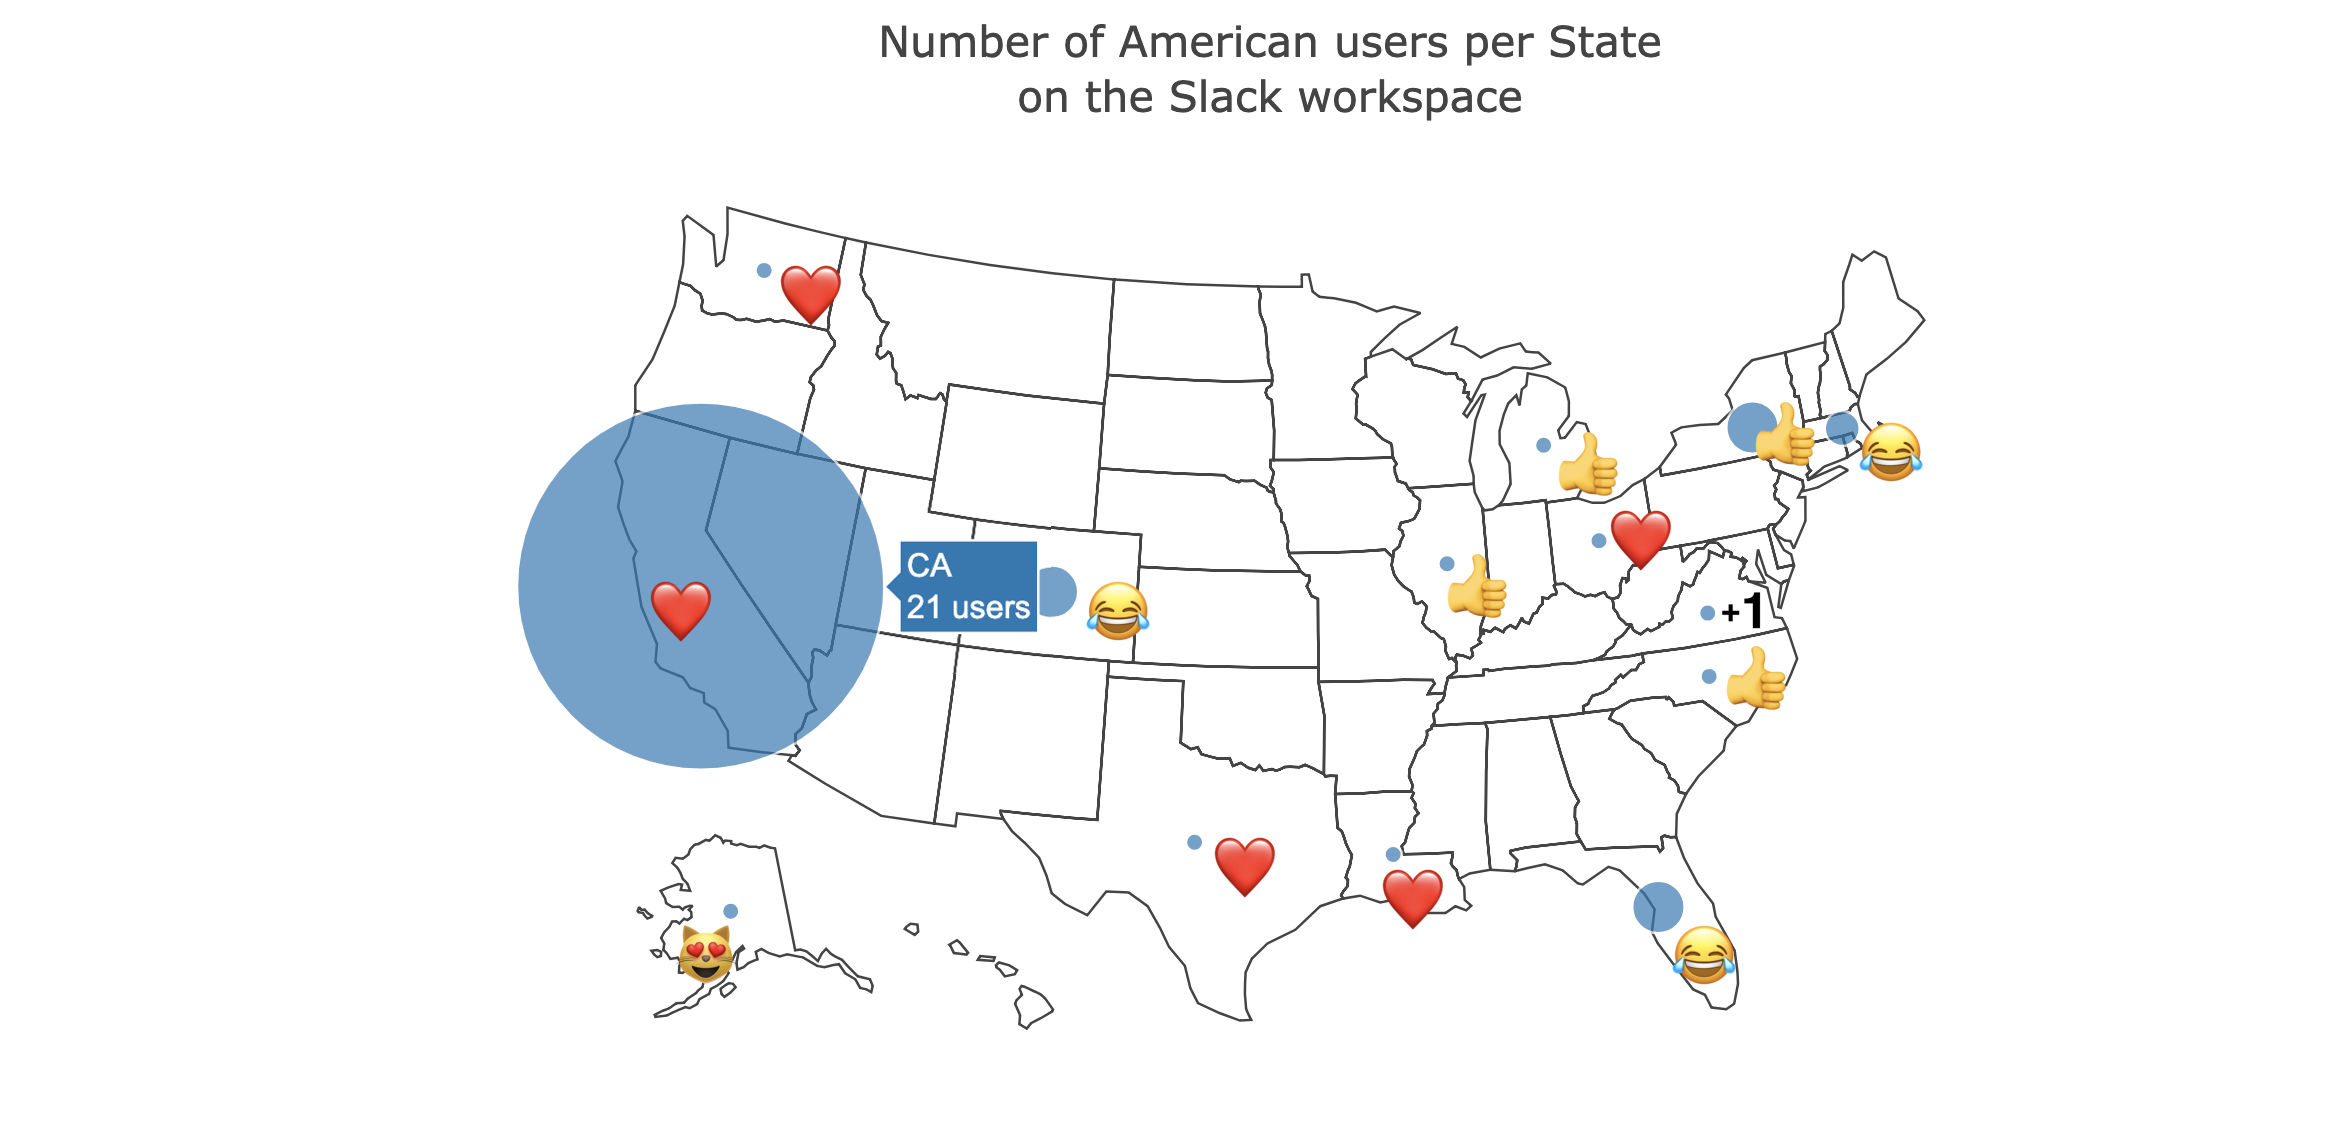

In [37]:
Image(filename="emojis2.png")

### Choropleth Map

In [38]:
first_plot = pd.DataFrame((df_user_reaction.groupby('country').sum().sum(axis=1)/users.groupby('country').count().member_id))
first_plot.columns = ['count']
first_plot['codes'] = ['ARG','ARM','BRA','CAN','CHN','COL','CUB','GBR', 'DEU', 'IND', 'KOR', 'MYS', 'PER', 'RUS', 'SGP', 'ESP', 'TWN', 'TUN', 'USA', 'VNM']
first_plot = first_plot.reset_index()
first_plot.head()

,country,count,codes
0,Argentina,41.00000,ARG
1,Armenia,835.00000,ARM
2,Brazil,227.00000,BRA
3,Canada,217.50000,CAN
4,China,313.96875,CHN


In [39]:
first_plot0 = pd.DataFrame(df_user_reaction.groupby('country').sum().sum(axis=1))
first_plot0.columns = ['count']
first_plot0['codes'] = ['ARG','ARM','BRA','CAN','CHN','COL','CUB','GBR', 'DEU', 'IND', 'KOR', 'MYS', 'PER', 'RUS', 'SGP', 'ESP', 'TWN', 'TUN', 'USA', 'VNM']
first_plot0 = first_plot0.reset_index()

data_plot0 = [go.Choropleth(
                locations = first_plot0['codes'],
                z = first_plot0['count'],
                text = [f"{country}<br># reactions: {reacs:,}<br># users: {users}" for reacs,users,country,scaled in zip(df_user_reaction.groupby('country').sum().sum(axis=1).values,users.groupby('country').count().member_id.values,first_plot.country.values,first_plot['count'].values)],
                hoverinfo = 'text',
                colorscale= 'Greens',
                reversescale = True,
                colorbar = go.choropleth.ColorBar(
                title = 'Number of reactions'),
                marker = go.choropleth.Marker(
                    line = go.choropleth.marker.Line(
                    color = 'rgb(180,180,180)',
                    width = 0.7
                )),
            )]

layout = go.Layout(
            title = go.layout.Title(
            text = 'Number of Slack reactions<br>per country of origin'
            ),
            geo = go.layout.Geo(
                showframe = False,
                showcountries = False,
                coastlinewidth=0.08,
                showcoastlines = True
            ),)

In [40]:
fig = go.Figure(data = data_plot0, layout = layout)
iplot(fig, filename = 'd3-world-map')

In [41]:
data_plot = [go.Choropleth(
                locations = first_plot['codes'],
                z = first_plot['count'],
                text = [f"{country}<br># reactions: {reacs:,}<br># users: {users}<br>scaled: {scaled}" for reacs,users,country,scaled in zip(df_user_reaction.groupby('country').sum().sum(axis=1).values,users.groupby('country').count().member_id.values,first_plot.country.values,first_plot['count'].values)],
                hoverinfo = 'text',
                colorscale= 'Greens',
                reversescale = True,
                colorbar = go.choropleth.ColorBar(
                title = 'Number of reactions<br>(Scaled)'),
                marker = go.choropleth.Marker(
                    line = go.choropleth.marker.Line(
                    color = 'rgb(180,180,180)',
                    width = 0.7
                )),
            )]

layout = go.Layout(
            title = go.layout.Title(
            text = 'Scaled number of Slack reactions<br>per country of origin'
            ),
            geo = go.layout.Geo(
                showframe = False,
                showcountries = False,
                coastlinewidth=0.08,
                showcoastlines = True
            ),)

In [42]:
fig = go.Figure(data = data_plot, layout = layout)
iplot(fig, filename = 'd3-world-map')

In [43]:
first_plot2 = first_plot[first_plot['country']!="Colombia"]
data_plot2 = [go.Choropleth(
                locations = first_plot2['codes'],
                z = first_plot2['count'],
                text = [f"{country}<br># reactions: {reacs:,}<br># users: {users}<br>scaled: {scaled}" for reacs,users,country,scaled in zip(df_user_reaction.groupby('country').sum().sum(axis=1).values,users.groupby('country').count().member_id.values,first_plot.country.values,first_plot['count'].values)][:5]+[f"{country}<br># reactions: {reacs:,}<br># users: {users}<br>scaled: {scaled}" for reacs,users,country,scaled in zip(df_user_reaction.groupby('country').sum().sum(axis=1).values,users.groupby('country').count().member_id.values,first_plot.country.values,first_plot['count'].values)][6:],
                hoverinfo = 'text',
                colorscale= 'Greens',
                reversescale = True,
                colorbar = go.choropleth.ColorBar(
                title = 'Number of reactions<br>(Scaled)'),
                marker = go.choropleth.Marker(
                    line = go.choropleth.marker.Line(
                    color = 'rgb(180,180,180)',
                    width = 0.7
                )),
            )]

layout = go.Layout(
            title = go.layout.Title(
            text = 'Scaled number of Slack reactions<br>per country of origin<br>(without Colombia)'
            ),
            geo = go.layout.Geo(
                showframe = False,
                showcountries = False,
                coastlinewidth=0.08,
                showcoastlines = True
            ),)

In [44]:
fig = go.Figure(data = data_plot2, layout = layout)
iplot(fig, filename = 'd3-world-map')

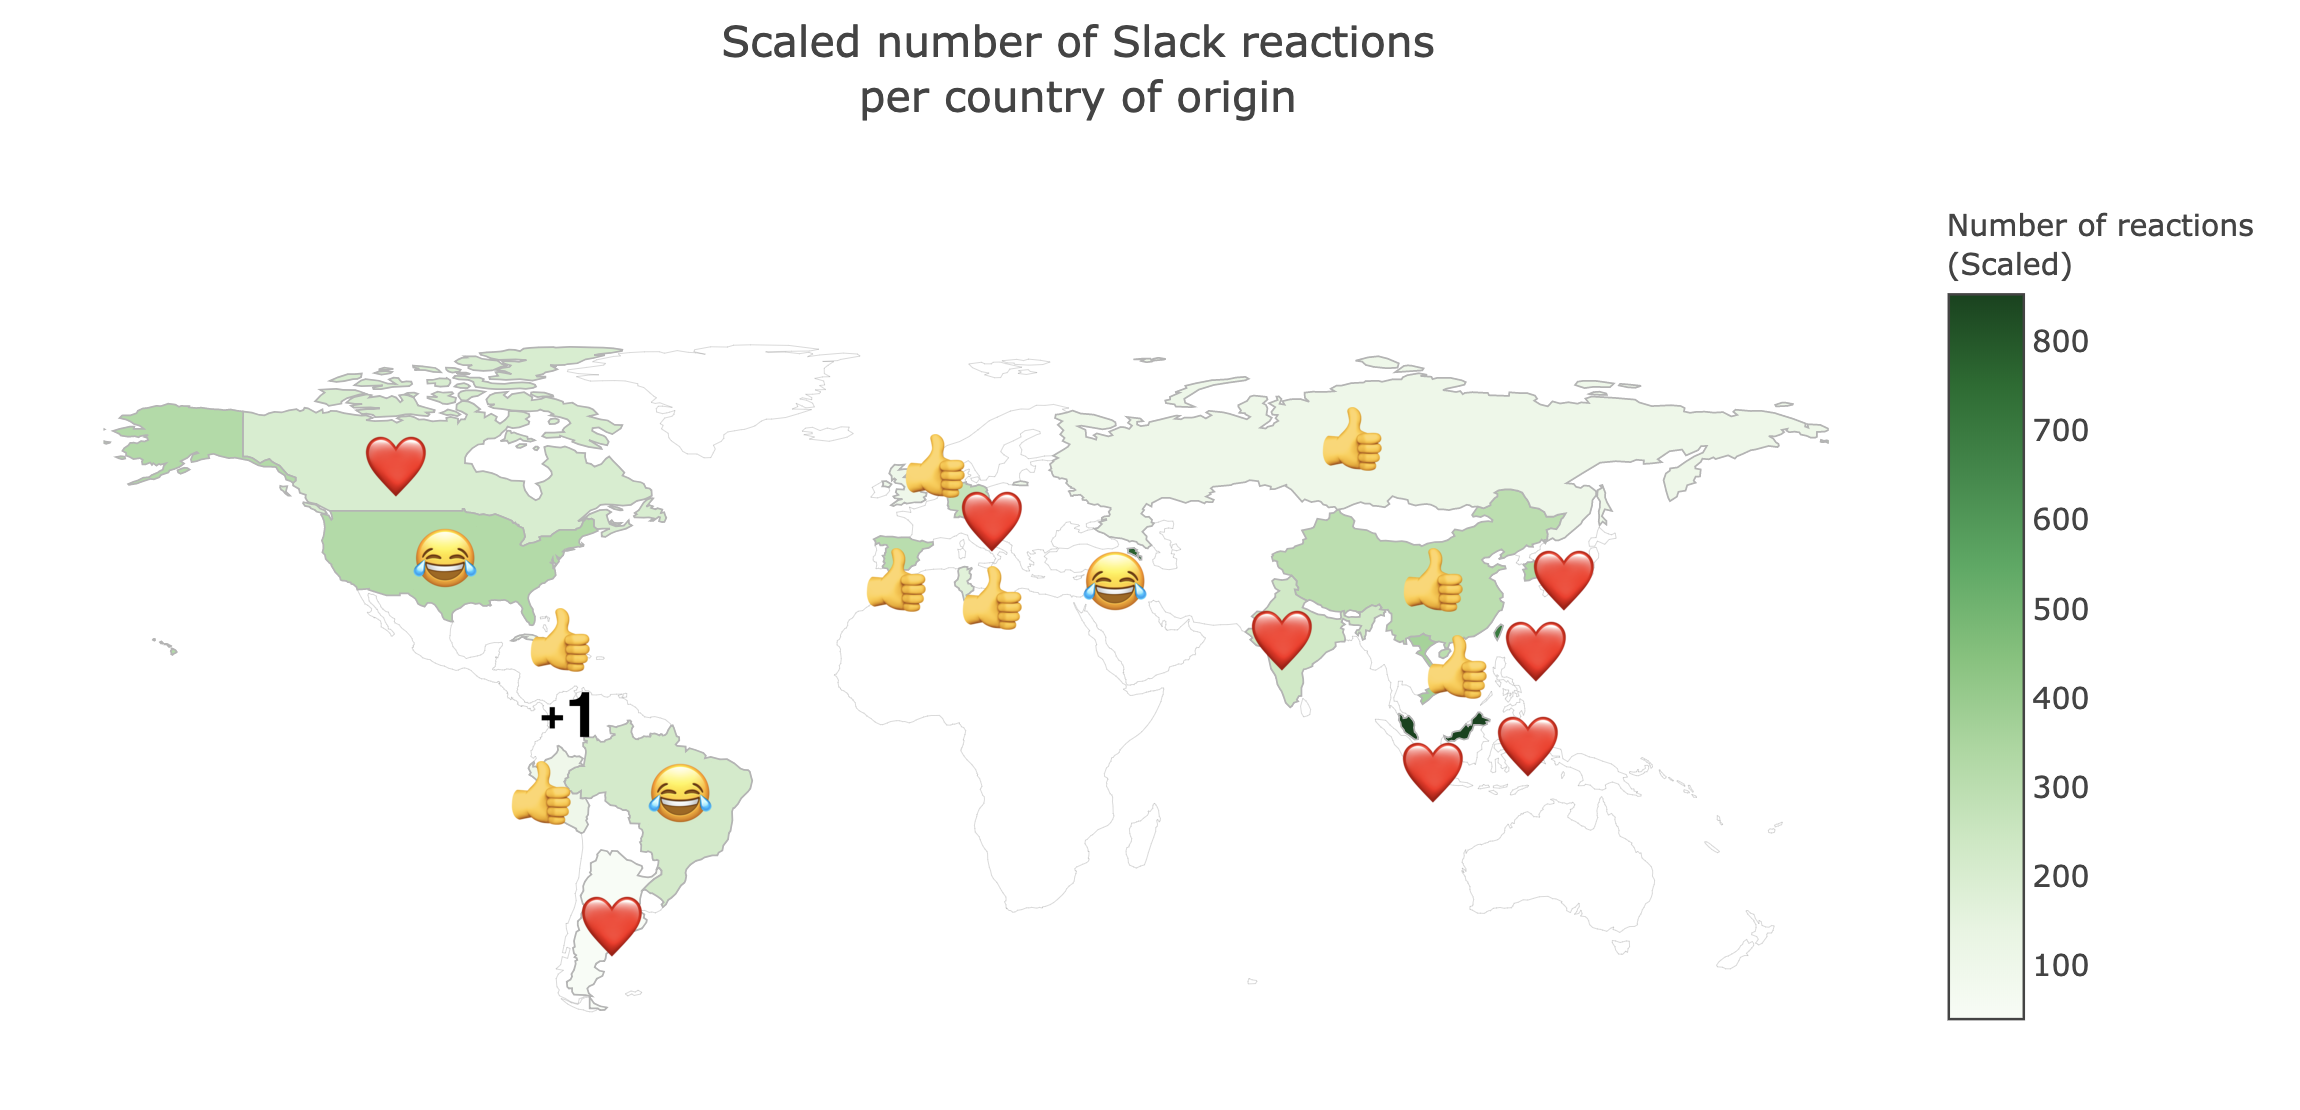

In [45]:
Image(filename="emojis.png")

### Connection Map

In [46]:
msg_rc = [(user,message) for user,message in zip(messages.user.values, messages.reactions.values) if message is not None]

In [47]:
all_msg_rc = []

for msgs in msg_rc:
    for msg in msgs[1]:
        msg['user_posted'] = msgs[0]
        all_msg_rc.append(msg)

In [48]:
tups = {}

for ru in all_msg_rc:
    reaction = ru['name']
    to_user = ru['user_posted']
    for from_user in ru['users']:
        pair = (reaction,from_user,to_user)
        if pair not in tups:
            tups[pair] = 1
        else:
            tups[pair] = tups[pair]+1

In [49]:
tups = [list((tup[0],str(tup[1])+":::"+str(tup[2]),count)) for tup,count in zip(tups.keys(),tups.values())]

In [50]:
df_user_reaction2 = pd.DataFrame(tups).set_index([1,0]).rename_axis([None,None]).unstack()[2].fillna(0).astype(int).reset_index()

In [51]:
df_user_reaction2['from'] = df_user_reaction2['index'].apply(lambda users: users.split(":::")[0])
df_user_reaction2['to'] = df_user_reaction2['index'].apply(lambda users: users.split(":::")[1])

df_user_reaction2 = df_user_reaction2[df_user_reaction2['to']!="nan"]

df_user_reaction2['type_from'] = df_user_reaction2['from'].apply(lambda user: users[users['member_id']==user].member_type.values[0])
df_user_reaction2['type_to'] = df_user_reaction2['to'].apply(lambda user: users[users['member_id']==user].member_type.values[0])

df_user_reaction2 = df_user_reaction2[df_user_reaction2['type_from']=="student"]
df_user_reaction2 = df_user_reaction2[df_user_reaction2['type_to']=="student"]

df_user_reaction2['country_from'] = df_user_reaction2['from'].apply(lambda user: users[users['member_id']==user].country.values[0])
df_user_reaction2['country_to'] = df_user_reaction2['to'].apply(lambda user: users[users['member_id']==user].country.values[0])

df_user_reaction2 = df_user_reaction2[df_user_reaction2['country_from'].isin(["China","USA"])]
df_user_reaction2 = df_user_reaction2[df_user_reaction2['country_to'].isin(["China","USA"])]

In [52]:
toChina = df_user_reaction2[df_user_reaction2['country_to']=="China"].groupby(['country_from']).sum().reset_index()
toUSA = df_user_reaction2[df_user_reaction2['country_to']=="USA"].groupby(['country_from']).sum().reset_index()

In [53]:
# From American students to Chine students
toChina[toChina['country_from']=="USA"].loc[1][1:].sort_values(ascending=False)[:10]

plus_one                         209
joy                              187
heart                            103
+1                                99
plus_ten                          37
wendy_one                         35
jeffsmile                         34
rolling_on_the_floor_laughing     28
amaze                             27
100                               25
Name: 1, dtype: object

In [54]:
# From Chinese students to American students
toUSA[toUSA['country_from']=="China"].loc[0][1:].sort_values(ascending=False)[:10]

plus_one                         268
+1                               213
joy                              165
heart                            121
rolling_on_the_floor_laughing     53
clapping                          52
plus_ten                          39
birthday                          38
clap                              38
heart_eyes_cat                    37
Name: 0, dtype: object

In [55]:
data = [go.Scattergeo(
    lat=[35, 35],
    lon=[100, -100],
    mode='lines',
    text="From the USA to China",
    hoverinfo='text',
    line=go.scattergeo.Line(
        width=2,
        color='brown',
    ),
),
    go.Scattergeo(
    lat=[25, 35],
    lon=[110, -110],
    mode='lines',
    text="From China to the USA",
    hoverinfo='text',
    line=go.scattergeo.Line(
        width=2,
        color='brown',
    )), go.Choropleth(
    locations=['USA', 'CHN'],
    z=[1, 1],
    hoverinfo='skip',
    colorscale='YlOrRd',
    showscale=False,
    marker=go.choropleth.Marker(
        line=go.choropleth.marker.Line(
            color='rgb(180,180,180)',
            width=0.7
        )),
)]

In [56]:
layout = go.Layout(
    title='Reactions between Chinese and American students',
    showlegend = False,
    geo = go.layout.Geo(
        scope="world",
        showframe = False,
        showcountries = False,
        coastlinewidth=0.5,
        showcoastlines = True
    )
)

In [57]:
fig = go.Figure(data = data, layout = layout)
iplot(fig)

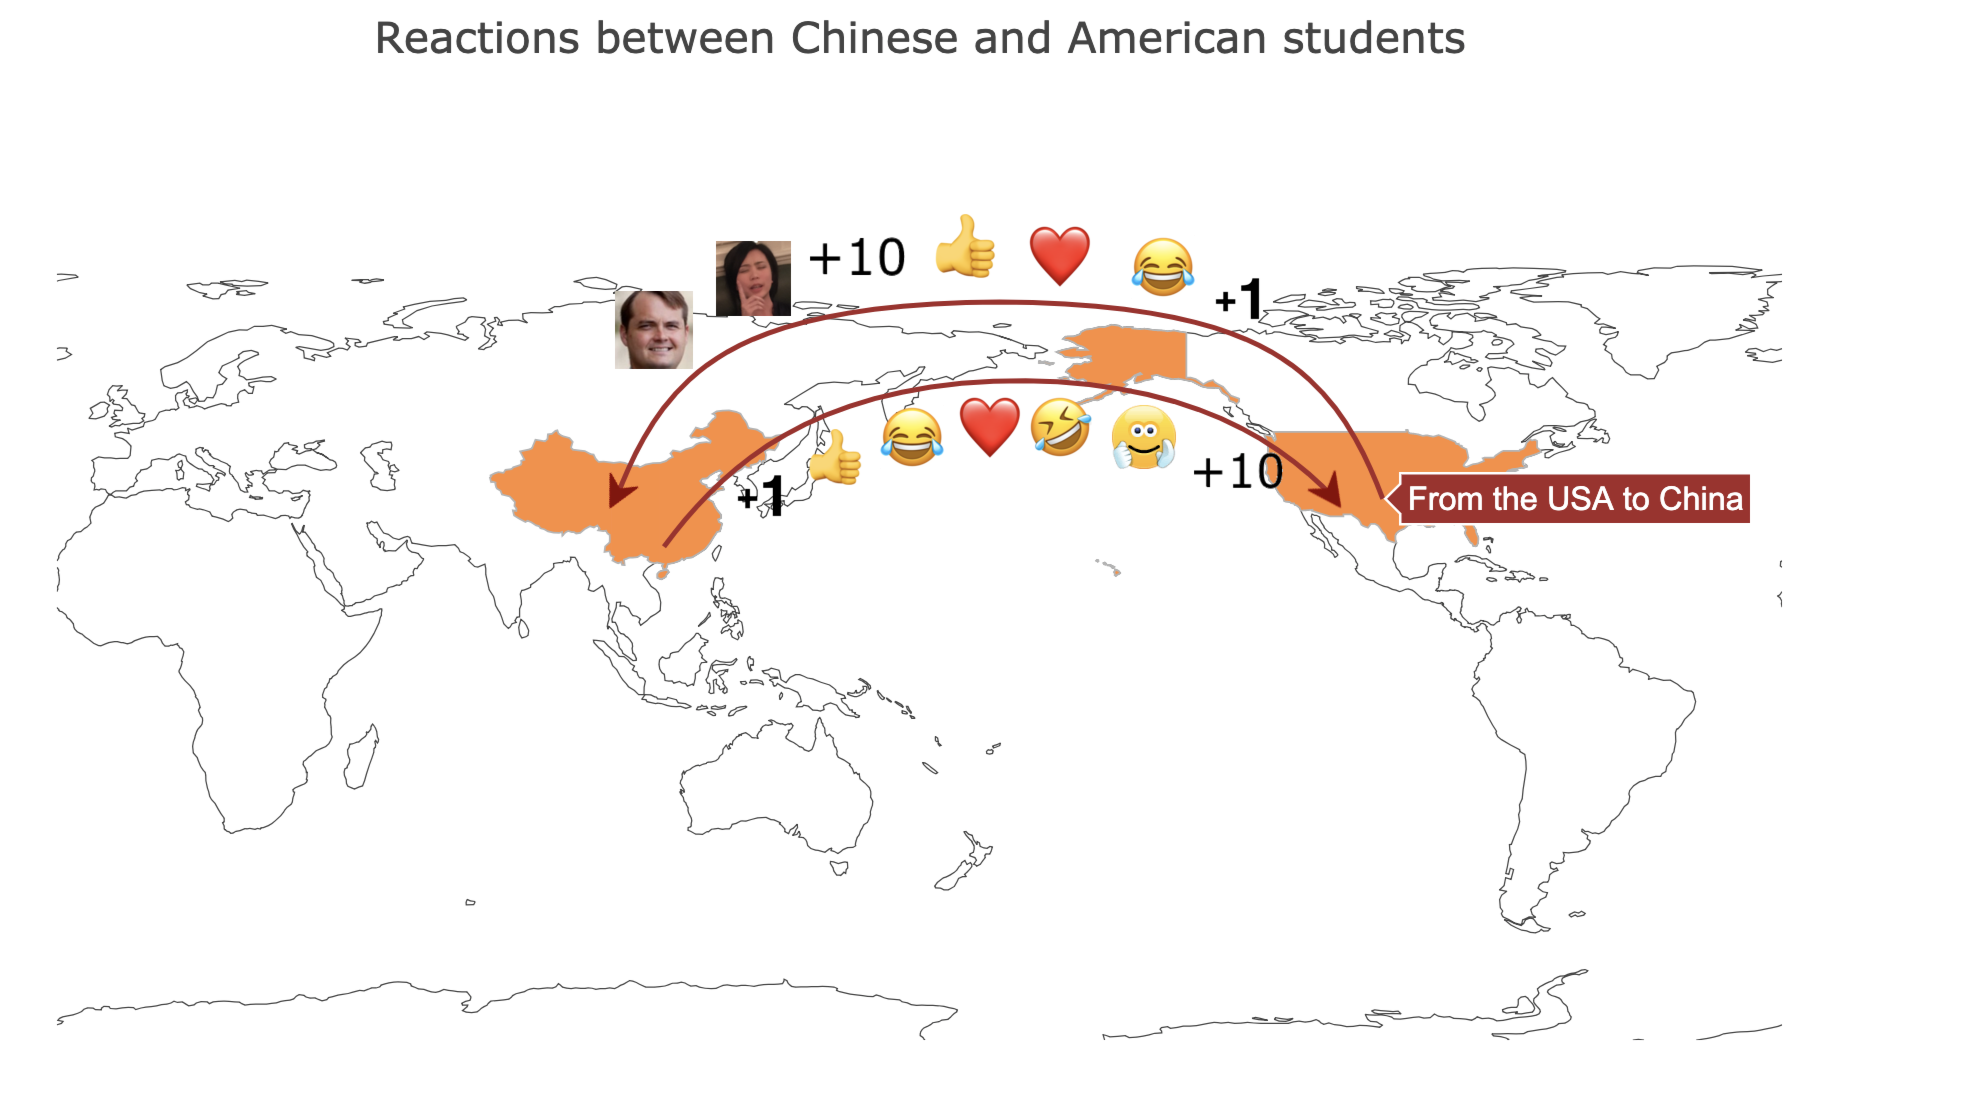

In [58]:
Image(filename="emojis3.png")

### Heat Map

In [59]:
msg_rc = [(user,message) for user,message in zip(messages.user.values, messages.reactions.values) if message is not None]

In [60]:
all_msg_rc = []

for msgs in msg_rc:
    for msg in msgs[1]:
        msg['user_posted'] = msgs[0]
        all_msg_rc.append(msg)

In [61]:
from_name = users[users['member_id']==from_user].member_name.values[0].split()

In [62]:
tups = {}

for ru in all_msg_rc:
    reaction = ru['name']
    to_user = ru['user_posted']
    if str(to_user) != "nan" and users[users['member_id']==to_user].member_type.values[0] in ['professor', 'student']:
        to_user = users[users['member_id']==to_user].member_name.values[0].split()
        if to_user[0] == "Brian":
            to_user = f"{to_user[0]} {to_user[1][0]}."
        else:
            to_user = to_user[0]
        for from_user in ru['users']:
            from_name = users[users['member_id']==from_user].member_name.values[0].split()
            if users[users['member_id']==from_user].member_type.values[0] in ['professor', 'student']:
                if from_name[0] == "Brian":
                    from_name = f"{from_name[0]} {from_name[1][0]}."
                else:
                    from_name = from_name[0]
                pair = (from_name,to_user)
                if pair not in tups:
                    tups[pair] = 1
                else:
                    tups[pair] = tups[pair]+1

In [63]:
sorted(tups.items(), key=lambda kv: kv[1], reverse=True)[:10]

[(('Victoria', 'Viviana'), 181),
 (('Wendy', 'Viviana'), 173),
 (('Jon-Ross', 'Viviana'), 169),
 (('Viviana', 'Diane'), 157),
 (('Viviana', 'Jon-Ross'), 151),
 (('Viviana', 'Brian S.'), 136),
 (('Viviana', 'Rebecca'), 127),
 (('Viviana', 'Jeff'), 126),
 (('Sarah', 'Viviana'), 125),
 (('Viviana', 'Terence'), 115)]

In [64]:
sorted(tups.items(), key=lambda kv: kv[1], reverse=True)[-10:]

[(('Phil', 'Xinran'), 1),
 (('Randy', 'Yixin'), 1),
 (('Julia', 'Yixin'), 1),
 (('Adam', 'Kirsten'), 1),
 (('Paul', 'David'), 1),
 (('Louise', 'Xinran'), 1),
 (('Randy', 'Lance'), 1),
 (('Yixin', 'Tomo'), 1),
 (('David', 'Darren'), 1),
 (('Rebecca', 'Ben'), 1)]

In [65]:
tups = [list((tup[0],tup[1],count)) for tup,count in zip(tups.keys(),tups.values())]

In [66]:
df_user_reaction3 = pd.DataFrame(tups).set_index([1,0]).rename_axis([None,None]).unstack()[2].fillna(0).astype(int)

In [67]:
df_user_reaction3.head()

,Abbie,Adam,Aditi,Alan,Aleks,Anish,Anna,Anush,Ben,Bowen,...,Xu,Xuemei,Yannet,Yihan,Yixin,Yuhan,ZHI,Zack,Zhe,Ziyu
Abbie,0,0,1,0,0,0,0,1,3,0,...,1,0,0,0,4,0,0,0,0,2
Adam,1,0,2,3,0,2,1,9,14,2,...,4,2,1,2,6,8,0,0,0,2
Aditi,0,0,0,0,0,0,0,2,0,1,...,0,0,0,0,0,0,0,0,0,0
Alan,3,2,0,9,0,6,0,16,7,2,...,1,0,0,3,6,2,0,4,1,3
Aleks,1,0,5,3,0,1,0,8,4,6,...,0,0,0,3,2,3,0,2,0,1


In [68]:
data = [go.Heatmap(z=df_user_reaction3.values.tolist(), colorscale='Hot', reversescale=False,
                   x=df_user_reaction3.index.values.tolist(),
                   y=df_user_reaction3.index.values.tolist())]

layout = go.Layout(
    title='🔥 Reactions Heatmap 🔥',
    xaxis = dict(title="FROM"),
    yaxis = dict(title="TO"),
    width=1000,
    height=1000,
    margin= {"t": 70, "b": 120}
)

fig = go.Figure(data = data, layout = layout)
iplot(fig)

### Stacked Area

In [69]:
trace1 = go.Histogram(x=list(messages.groupby(['user']).sum().count_reactions.values),
                      opacity=0.9, nbinsx = 5, name="Reactions")

trace2 = go.Histogram(x=list(messages.groupby(['user']).sum().count_messages.values),
                      opacity=0.9, nbinsx = 5, name="Messages")

In [70]:
data = [trace1,trace2]

layout = go.Layout(barmode='overlay',
                   title='Reactions and Messages received on Slack',
                   xaxis=dict(title='Number of reactions/messages received'),
                   yaxis=dict(title='Number of users')
                  )

fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Treemaping

In [71]:
first_plot['num_students'] = users.groupby('country').count().member_id.values
first_plot.columns = ['country','num_reactions', 'codes', 'num_users']
first_plot

,country,num_reactions,codes,num_users
0,Argentina,41.000000,ARG,1
1,Armenia,835.000000,ARM,1
2,Brazil,227.000000,BRA,1
3,Canada,217.500000,CAN,2
4,China,313.968750,CHN,32
5,Colombia,2773.000000,COL,1
6,Cuba,98.000000,CUB,1
7,England,109.000000,GBR,1
8,Germany,294.000000,DEU,1
9,India,247.142857,IND,7


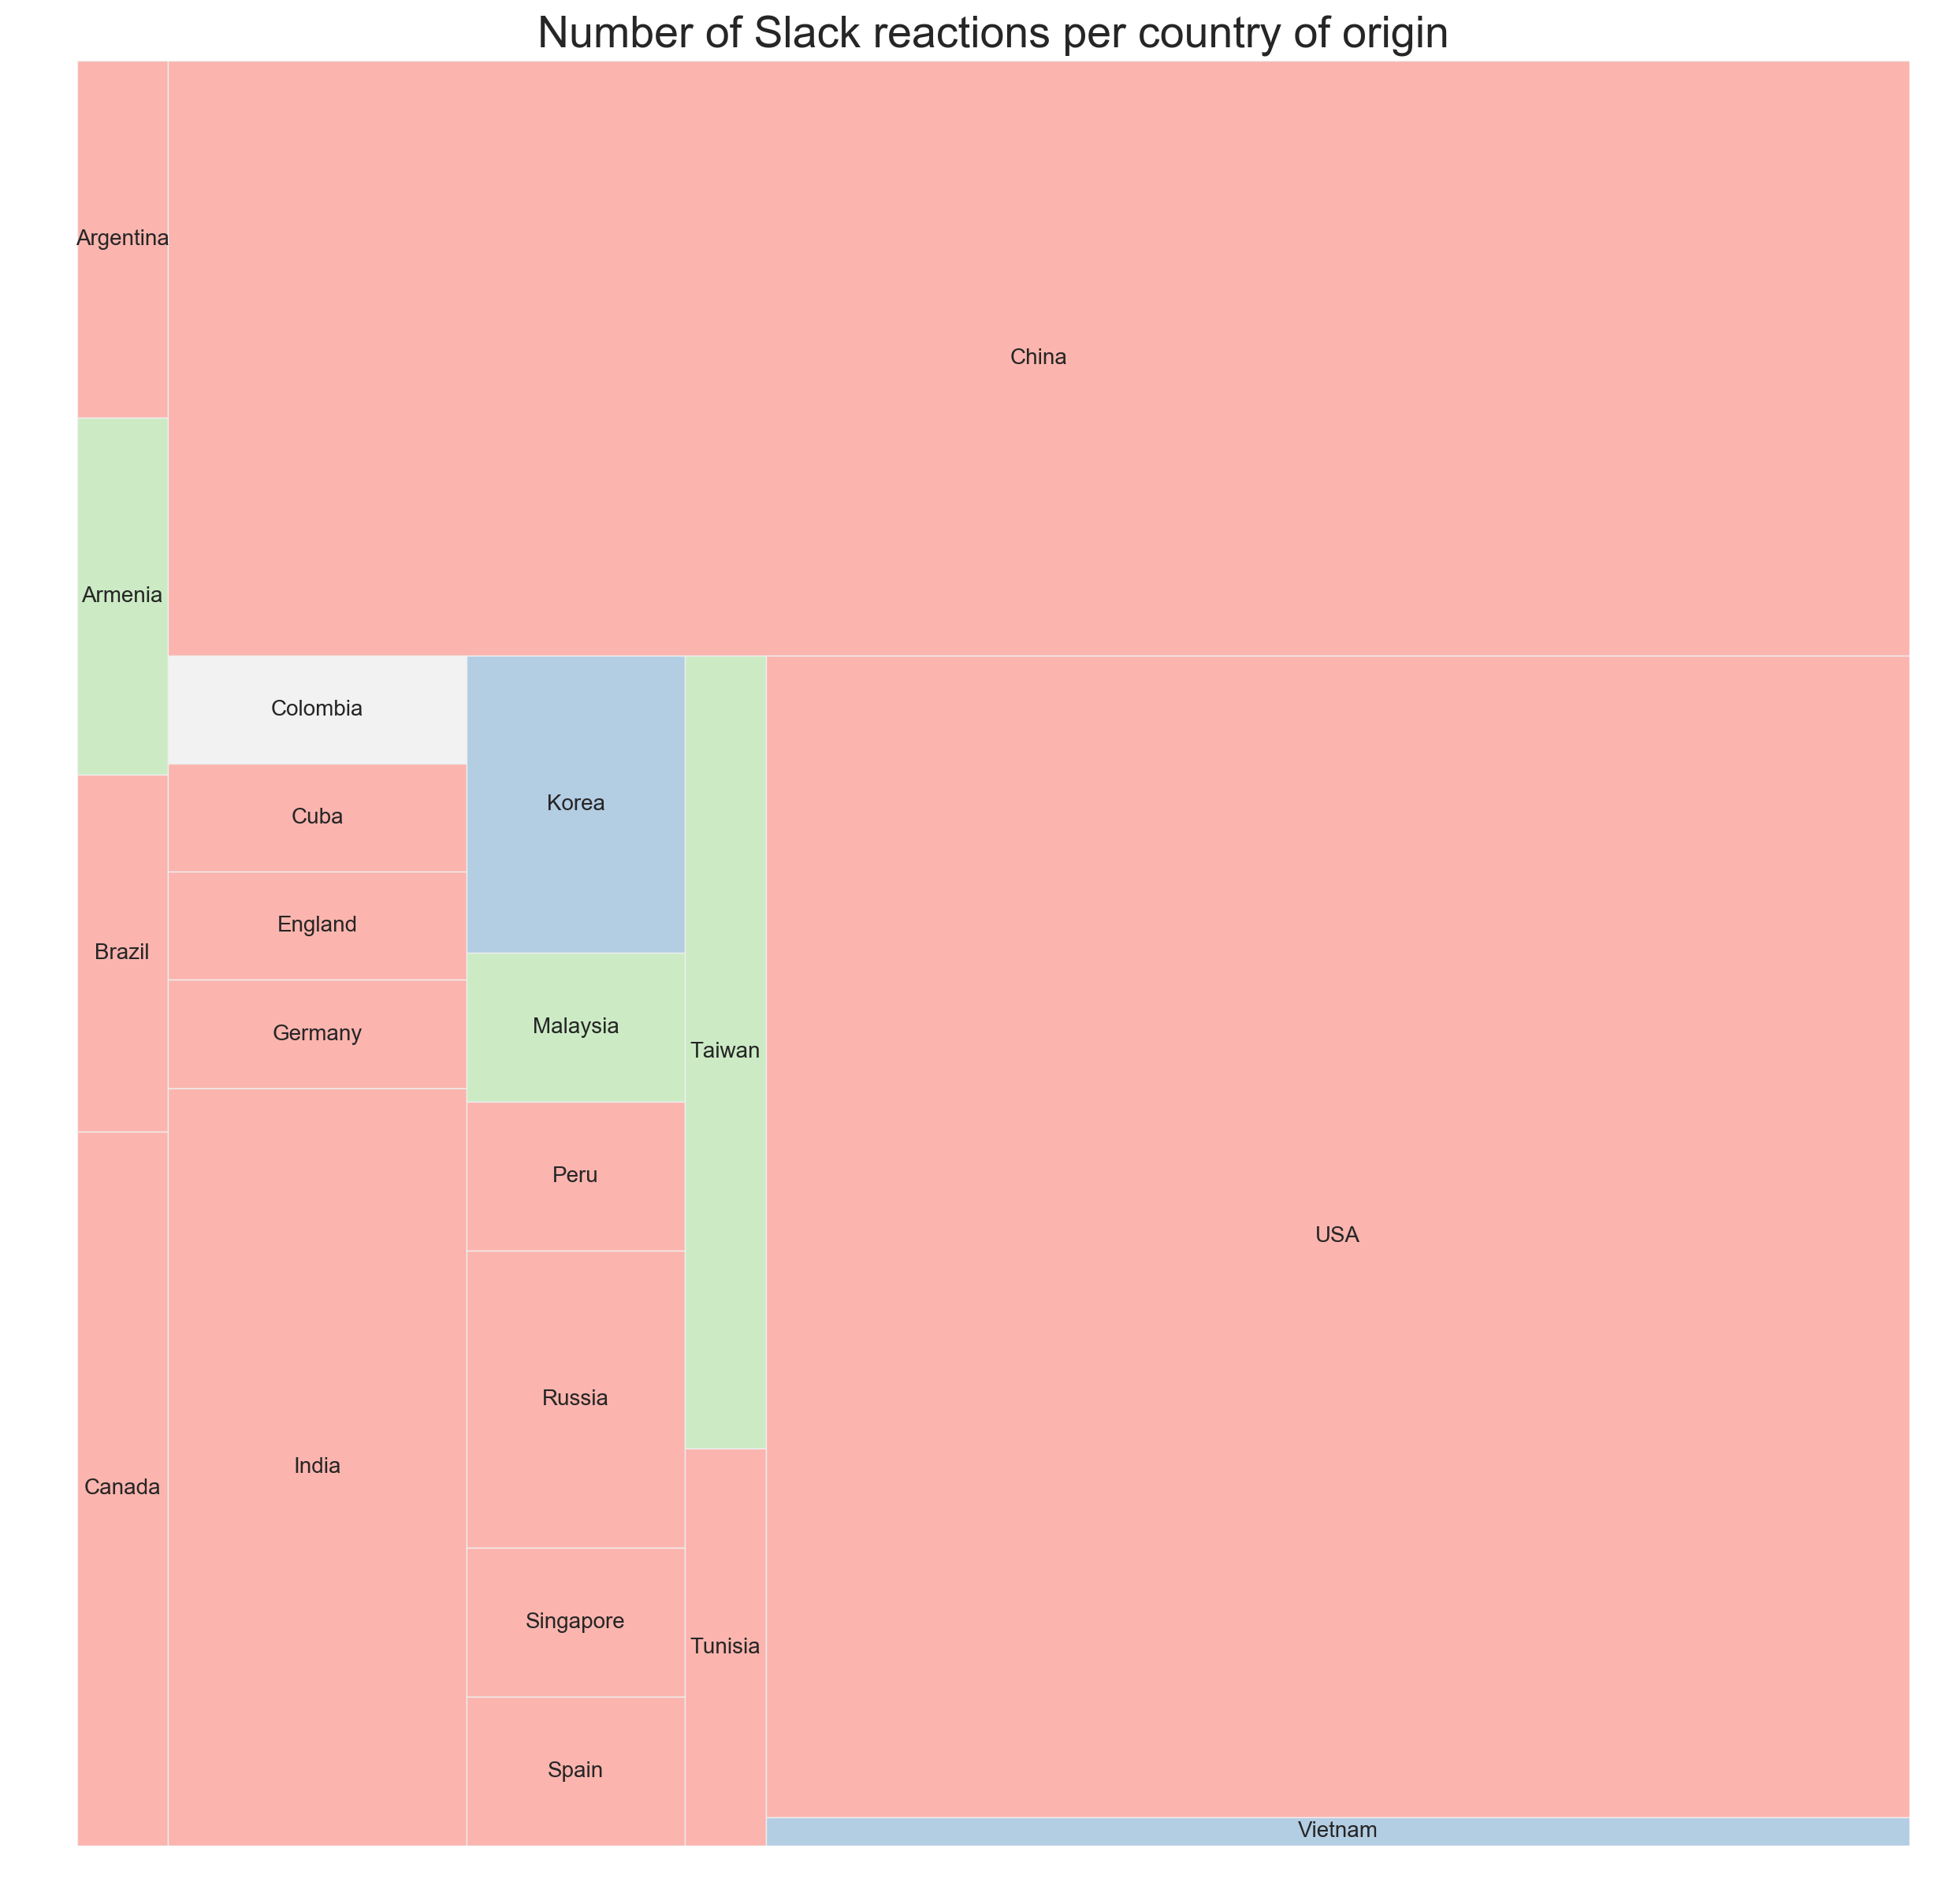

In [72]:
matplotlib.rcParams['figure.figsize'] = (15,15)
matplotlib.rcParams['figure.dpi'] = 200
style.use('ggplot')

fig, ax = plt.subplots()

cmap = matplotlib.cm.Pastel1

mini = min(first_plot["num_reactions"])
maxi = max(first_plot["num_reactions"])

norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in first_plot["num_reactions"]]

squarify.plot(sizes=first_plot["num_users"], label=first_plot["country"], alpha=1, color=colors)

plt.axis('off')
plt.gca().invert_yaxis()

plt.title("Number of Slack reactions per country of origin", fontsize=20);